In [204]:
import numpy as np
import matplotlib.pyplot as plt
from argparse import Namespace
import sys
import torch
sys.path.append("../scripts")

from dataset_omniweb import omniweb_all_columns, omniweb_yeojohnson_lambdas, omniweb_mean_of_yeojohnson, omniweb_std_of_yeojohnson, omniweb_all_columns_yeojohnson_lambdas, omniweb_all_columns_mean_of_yeojohnson, omniweb_all_columns_std_of_yeojohnson
from dataset_celestrak import CelesTrak_mean_of_log1p, CelesTrak_std_of_log1p
from util import yeojohnson, yeojhonson_inverse
from dataset_set import set_yeojohnson_lambdas, set_mean_of_yeojohnson, set_std_of_yeojohnson, set_all_columns_yeojohnson_lambdas, set_all_columns_mean_of_yeojohnson, set_all_columns_std_of_yeojohnson, set_all_columns

args = Namespace(
    model = "gnn", # "lstm"
    # event_id = "G0H12-201804202100",
    # event_id = "G2H12-201509071500",
    event_id = "G4H12-202304231500",
    )

target_folder = f"../data/{args.model}-final/plots/{args.event_id}/"
combined_seq_original = np.load(f"../data/{args.model}-final/test-long-horizon-event-{args.event_id}-original.npy")
combined_seq_forecast = np.load(f"../data/{args.model}-final/test-long-horizon-event-{args.event_id}-forecast.npy")
# combined_seq_forecast = np.load(f"/home/jupyter/halil_debug/ioncastgnn-fulldataset-sunlock-dilation64-nonresidual-Oct-5/test-long-horizon-event-{event_id}-forecast.npy")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "mathtext.fontset": "cm",
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
})

In [220]:
combined_seq_forecast.shape, combined_seq_original.shape

((48, 44, 180, 360), (48, 44, 180, 360))

In [205]:
class OMNIWeb_unnormalize:
    def __init__(self, column):
        self.column = column
    def normalize_data(self, data): 
        data=data.permute(0,2,3,1)
        if self.column == omniweb_all_columns:
            data = yeojohnson(data, omniweb_all_columns_yeojohnson_lambdas)
            data = (data - omniweb_all_columns_mean_of_yeojohnson) / omniweb_all_columns_std_of_yeojohnson
        else:
            lambdas = torch.tensor([omniweb_yeojohnson_lambdas[col] for col in self.column], dtype=torch.float32)
            means = torch.tensor([omniweb_mean_of_yeojohnson[col] for col in self.column], dtype=torch.float32)
            stds = torch.tensor([omniweb_std_of_yeojohnson[col] for col in self.column], dtype=torch.float32)
            data = yeojohnson(data, lambdas)
            data = (data - means) / stds
        data=data.permute(0,3,1,2)
        return data

    def unnormalize_data(self, data):
        SHAPE = data.shape 
        data=data.permute(0,2,3,1)
        if self.column == omniweb_all_columns:
            data = data * omniweb_all_columns_std_of_yeojohnson + omniweb_all_columns_mean_of_yeojohnson
            data = yeojhonson_inverse(data.flatten(), (omniweb_all_columns_yeojohnson_lambdas[None,None,None,:] * torch.ones_like(data)).flatten())
            data = torch.reshape(data, (SHAPE[0], SHAPE[2], SHAPE[3], SHAPE[1]))
        else:
            lambdas = torch.tensor([omniweb_yeojohnson_lambdas[col] for col in self.column], dtype=torch.float32)
            means = torch.tensor([omniweb_mean_of_yeojohnson[col] for col in self.column], dtype=torch.float32)
            stds = torch.tensor([omniweb_std_of_yeojohnson[col] for col in self.column], dtype=torch.float32)
            data = data * stds + means
            print(data.shape, lambdas.shape)

            data = yeojhonson_inverse(data.flatten(), (lambdas[None,None,None,:].flatten() * torch.ones_like(data)).flatten())
            data = torch.reshape(data, (SHAPE[0], SHAPE[2], SHAPE[3], SHAPE[1]))
        data=data.permute(0,3,1,2)
        return data

class CelesTrak_unnormalize:
    def __init__(self, column):
        self.column = column
    def normalize_data(self, data):
        data = data.permute(0, 2, 3, 1)
        if self.column == ['Kp', 'Ap']:
            data = torch.log1p(data)
            data = (data - CelesTrak_mean_of_log1p) / CelesTrak_std_of_log1p
        elif self.column == ['Kp']:
            data = torch.log1p(data)
            data = (data - CelesTrak_mean_of_log1p[0]) / CelesTrak_std_of_log1p[0] # Kp
        elif self.column == ['Ap']:
            data = torch.log1p(data)
            data = (data - CelesTrak_mean_of_log1p[1]) / CelesTrak_std_of_log1p[1] # Ap
        else:
            raise ValueError(f"Unknown column configuration: {self.column}. Expected ['Kp', 'Ap'], ['Kp'], or ['Ap'].")
        data = data.permute(0, 3, 1, 2)
        return data
    
    def unnormalize_data(self, data):
        # SHAPE = data.shape 
        data = data.permute(0, 2, 3, 1)
        if self.column == ['Kp', 'Ap']:
            print(CelesTrak_std_of_log1p.shape, CelesTrak_mean_of_log1p.shape)
            print(data.shape)
            data = data * CelesTrak_std_of_log1p + CelesTrak_mean_of_log1p
            data = torch.expm1(data)
        elif self.column == ['Kp']:
            data = data * CelesTrak_std_of_log1p[0] + CelesTrak_mean_of_log1p[0] # Kp
            data = torch.expm1(data)
        elif self.column == ['Ap']:
            data = data * CelesTrak_std_of_log1p[1] + CelesTrak_mean_of_log1p[1] # Ap
            data = torch.expm1(data)
        else:
            raise ValueError(f"Unknown column configuration: {self.column}. Expected ['Kp', 'Ap'], ['Kp'], or ['Ap'].")
        data = data.permute(0,3, 1, 2)
        return data

class SET_unnormalize:
    def __init__(self, column):
        self.column = column

    def normalize_data(self, data): 
        data = data.permute(0,2,3,1)
        if self.column == set_all_columns:
            data = yeojohnson(data, set_all_columns_yeojohnson_lambdas[None, None, None, :])
            data = (data - set_all_columns_mean_of_yeojohnson) / set_all_columns_std_of_yeojohnson
        else:
            lambdas = torch.tensor([set_yeojohnson_lambdas[col] for col in self.column], dtype=torch.float32)
            means = torch.tensor([set_mean_of_yeojohnson[col] for col in self.column], dtype=torch.float32)
            stds = torch.tensor([set_std_of_yeojohnson[col] for col in self.column], dtype=torch.float32)
            data = yeojohnson(data, lambdas[None,None,None,:])
            data = (data - means) / stds
        data = data.permute(0,3,1,2)
        return data

    def unnormalize_data(self, data):
        SHAPE = data.shape 
        data = data.permute(0,2,3,1)
        if self.column == set_all_columns:
            data = data * set_all_columns_std_of_yeojohnson + set_all_columns_mean_of_yeojohnson
            data = yeojhonson_inverse(data.flatten(), (set_all_columns_yeojohnson_lambdas[None, None, None, :] * torch.ones_like(data)).flatten())
            data = torch.reshape(data, (SHAPE[0], SHAPE[2], SHAPE[3], SHAPE[1]))
        else:
            lambdas = torch.tensor([set_yeojohnson_lambdas[col] for col in self.column], dtype=torch.float32)
            means = torch.tensor([set_mean_of_yeojohnson[col] for col in self.column], dtype=torch.float32)
            stds = torch.tensor([set_std_of_yeojohnson[col] for col in self.column], dtype=torch.float32)
            data = data * stds + means
            data = yeojhonson_inverse(data.flatten(), (lambdas[None, None, None, :] * torch.ones_liek(data)).flatten())
            data = torch.reshape(data, (SHAPE[0], SHAPE[2], SHAPE[3], SHAPE[1]))
        data = data.permute(0,3,1,2)
        return data

In [206]:
combined_seq_original.shape, combined_seq_forecast.shape

((48, 44, 180, 360), (48, 44, 180, 360))

In [207]:
"""
JPLD channels:
    - Channel 0 (0): JPLD Dense TEC map.
Sunmoon channels:
    - Channel  0     (1):     Cosine of the Sun's zenith angle map.
    - Channels 1-3   (2-4):   Sun's subsolar point coordinates (normalized lat, cos(lon), sin(lon)).
    - Channels 4-6   (5-7):   Sun's antipode point coordinates (normalized lat, cos(lon), sin(lon)).
    - Channel  7     (8):     Earth-Sun distance (in Astronomical Units, AU).
    - Channel  8     (9):     Cosine of the Moon's zenith angle map.
    - Channels 9-11  (10-12): Moon's sublunar point coordinates (normalized lat, cos(lon), sin(lon)).
    - Channels 12-14 (13-15): Moon's antipode point coordinates (normalized lat, cos(lon), sin(lon)).
    - Channel  15    (16):    Earth-Moon distance (in Lunar Distances, LD).
    - Channels 16-17 (17-18): Cyclical features for the day of the year (sin, cos).

Quasi Dipole channels:
    - Channel 0 (19): Quasi-dipole latitude grid (sin).
    - Channel 1 (20): Quasi-dipole latitude grid (cos).
    - Channel 2 (21): Quasi-dipole longitude grid (sin).
    - Channel 3 (22): Quasi-dipole longitude grid (cos). [Note this channel was actually still the sin of the lon grid in the dataset class just fixed it now (Oct 10, 2025)]

Celestrak channels:
    - Channel 0 (23): Kp index.
    - Channel 1 (24): Ap index.

OMNI channels:
    - Channel 0 (25): omniweb__sym_d__[nT]
    - Channel 1 (26): omniweb__sym_h__[nT]
    - Channel 2 (27): omniweb__asy_d__[nT]
    - Channel 3 (28): omniweb__bx_gse__[nT]
    - Channel 4 (29): omniweb__by_gse__[nT]
    - Channel 5 (30): omniweb__bz_gse__[nT]
    - Channel 6 (31): omniweb__speed__[km/s]
    - Channel 7 (32): omniweb__vx_velocity__[km/s]
    - Channel 8 (33): omniweb__vy_velocity__[km/s]
    - Channel 9 (34): omniweb__vz_velocity__[km/s]

SET channels:
    - Channel 0 (35): space_environment_technologies__f107_obs__
    - Channel 1 (36): space_environment_technologies__f107_average__
    - Channel 2 (37): space_environment_technologies__s107_obs__
    - Channel 3 (38): space_environment_technologies__s107_average__
    - Channel 4 (39): space_environment_technologies__m107_obs__
    - Channel 5 (40): space_environment_technologies__m107_average__
    - Channel 6 (41): space_environment_technologies__y107_obs__
    - Channel 7 (42): space_environment_technologies__y107_average__
    - Channel 8 (43): JB08__d_st_dt__[K]
"""

"\nJPLD channels:\n    - Channel 0 (0): JPLD Dense TEC map.\nSunmoon channels:\n    - Channel  0     (1):     Cosine of the Sun's zenith angle map.\n    - Channels 1-3   (2-4):   Sun's subsolar point coordinates (normalized lat, cos(lon), sin(lon)).\n    - Channels 4-6   (5-7):   Sun's antipode point coordinates (normalized lat, cos(lon), sin(lon)).\n    - Channel  7     (8):     Earth-Sun distance (in Astronomical Units, AU).\n    - Channel  8     (9):     Cosine of the Moon's zenith angle map.\n    - Channels 9-11  (10-12): Moon's sublunar point coordinates (normalized lat, cos(lon), sin(lon)).\n    - Channels 12-14 (13-15): Moon's antipode point coordinates (normalized lat, cos(lon), sin(lon)).\n    - Channel  15    (16):    Earth-Moon distance (in Lunar Distances, LD).\n    - Channels 16-17 (17-18): Cyclical features for the day of the year (sin, cos).\n\nQuasi Dipole channels:\n    - Channel 0 (19): Quasi-dipole latitude grid (sin).\n    - Channel 1 (20): Quasi-dipole latitude gri

In [208]:
channels = np.arange(combined_seq_original.shape[1])
channel_names = [
      "JPLD_TEC",
      "Sun_zenith_cos",
      "Sun_subsolar_lat_sin",
      "Sun_subsolar_lon_cos",
      "Sun_subsolar_lon_sin",
      "Sun_antipode_lat_sin",
      "Sun_antipode_lon_cos",
      "Sun_antipode_lon_sin",
      "Earth-Sun_distance_(AU)",
      "Moon_zenith_cos",
      "Moon_sublunar_lat_sin",
      "Moon_sublunar_lon_cos",
      "Moon_sublunar_lon_sin",
      "Moon_antipode_lat_sin",
      "Moon_antipode_lon_cos",
      "Moon_antipode_lon_sin",
      "Earth-Moon_distance_(LD)",
      "Day_of_year_sin",
      "Day_of_year_cos",
      "Quasi-dipole_lat_sin",
      "Quasi-dipole_lat_cos",
      "Quasi-dipole_lon_sin",
      "Quasi-dipole_lon_cos",
      "Kp",
      "Ap",
      "omniweb__sym_d__[nT]",
      "omniweb__sym_h__[nT]",
      "omniweb__asy_d__[nT]",
      "omniweb__bx_gse__[nT]",
      "omniweb__by_gse__[nT]",
      "omniweb__bz_gse__[nT]",
      "omniweb__speed__[km_s]",
      "omniweb__vx_velocity__[km_s]",
      "omniweb__vy_velocity__[km_s]",
      "omniweb__vz_velocity__[km_s]",
      "space_environment_technologies__f107_obs__",
      "space_environment_technologies__f107_average__",
      "space_environment_technologies__s107_obs__",
      "space_environment_technologies__s107_average__",
      "space_environment_technologies__m107_obs__",
      "space_environment_technologies__m107_average__",
      "space_environment_technologies__y107_obs__",
      "space_environment_technologies__y107_average__",
      "JB08__d_st_dt__[K]"
      ]       
channel_names_unnormalize = [
      "JPLD_TEC",
      "Sun_zenith_cos",
      "Sun_subsolar_lat_sin",
      "Sun_subsolar_lon_cos",
      "Sun_subsolar_lon_sin",
      "Sun_antipode_lat_sin",
      "Sun_antipode_lon_cos",
      "Sun_antipode_lon_sin",
      "Earth-Sun_distance_(AU)",
      "Moon_zenith_cos",
      "Moon_sublunar_lat_sin",
      "Moon_sublunar_lon_cos",
      "Moon_sublunar_lon_sin",
      "Moon_antipode_lat_sin",
      "Moon_antipode_lon_cos",
      "Moon_antipode_lon_sin",
      "Earth-Moon_distance_(LD)",
      "Day_of_year_sin",
      "Day_of_year_cos",
      "Quasi-dipole_lat_sin",
      "Quasi-dipole_lat_cos",
      "Quasi-dipole_lon_sin",
      "Quasi-dipole_lon_cos",
      "Kp",
      "Ap",
      "omniweb__sym_d__[nT]",
      "omniweb__sym_h__[nT]",
      "omniweb__asy_d__[nT]",
      "omniweb__bx_gse__[nT]",
      "omniweb__by_gse__[nT]",
      "omniweb__bz_gse__[nT]",
      "omniweb__speed__[km/s]",
      "omniweb__vx_velocity__[km/s]",
      "omniweb__vy_velocity__[km/s]",
      "omniweb__vz_velocity__[km/s]",
      "space_environment_technologies__f107_obs__",
      "space_environment_technologies__f107_average__",
      "space_environment_technologies__s107_obs__",
      "space_environment_technologies__s107_average__",
      "space_environment_technologies__m107_obs__",
      "space_environment_technologies__m107_average__",
      "space_environment_technologies__y107_obs__",
      "space_environment_technologies__y107_average__",
      "JB08__d_st_dt__[K]"
      ]       
channel_names_figures = [
      "Total Electron Content",
      r"$\cos(\Theta_{s})$",
      "Sun_subsolar_lat_sin",
      "Sun_subsolar_lon_cos",
      "Sun_subsolar_lon_sin",
      "Sun_antipode_lat_sin",
      "Sun_antipode_lon_cos",
      "Sun_antipode_lon_sin",
      "Earth-Sun_distance_(AU)",
      "Moon_zenith_cos",
      "Moon_sublunar_lat_sin",
      "Moon_sublunar_lon_cos",
      "Moon_sublunar_lon_sin",
      "Moon_antipode_lat_sin",
      "Moon_antipode_lon_cos",
      "Moon_antipode_lon_sin",
      "Earth-Moon_distance_(LD)",
      "Day_of_year_sin",
      "Day_of_year_cos",
      "Quasi-dipole_lat_sin",
      "Quasi-dipole_lat_cos",
      "Quasi-dipole_lon_sin",
      "Quasi-dipole_lon_cos",
      r"Kp index",
      r"Ap index",
      r"SYM-D $[nT]$",
      r"SYM-H $[nT]$",
      r"AYM-D $[nT]$",
      r"$B_x$ $[nT]$",
      r"$B_y$ $[nT]$",
      r"$B_z$ $[nT]$",
      r"Speed $[km/s]$",
      r"$v_x$ $[km/s]$",
      r"$v_y$ $[km/s]$",
      r"$v_z$ $[km/s]$",
      r"Raw F10.7",
      r"Averaged F10.7",
      r"Raw S10.7",
      r"Averaged S10.7",
      r"Raw M10.7",
      r"Averaged M10.7",
      r"Raw Y10.7",
      r"Averaged Y10.7",
      r"JB2008 $[K]$"
      ]       
JPLD = channels[0:1]
SUNMOON = channels[1:19]
QUASI = channels[19:23]
CELESTRAK = channels[23:25]
OMNI = channels[25:35]
SET =  channels[35:44]

print(f"JPLD channels:{JPLD}\n" +
      f"SUNMOON channels:{SUNMOON}\n" +
      f"QUASI channels:{QUASI}\n" +
      f"CELESTRAK channels:{CELESTRAK}\n" + 
      f"OMNI channels:{OMNI}\n" +
      f"SET channels:{SET}")

# print shapes of each channel group
print(f"JPLD shape: {combined_seq_original[:, JPLD, :, :].shape}\n" +
      f"SUNMOON shape: {combined_seq_original[:, SUNMOON, :, :].shape}\n" +
      f"QUASI shape: {combined_seq_original[:, QUASI, :, :].shape}\n" +
      f"CELESTRAK shape: {combined_seq_original[:, CELESTRAK, :, :].shape}\n" +
      f"OMNI shape: {combined_seq_original[:, OMNI, :, :].shape}\n" +
      f"SET shape: {combined_seq_original[:, SET, :, :].shape}")


JPLD channels:[0]
SUNMOON channels:[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
QUASI channels:[19 20 21 22]
CELESTRAK channels:[23 24]
OMNI channels:[25 26 27 28 29 30 31 32 33 34]
SET channels:[35 36 37 38 39 40 41 42 43]
JPLD shape: (48, 1, 180, 360)
SUNMOON shape: (48, 18, 180, 360)
QUASI shape: (48, 4, 180, 360)
CELESTRAK shape: (48, 2, 180, 360)
OMNI shape: (48, 10, 180, 360)
SET shape: (48, 9, 180, 360)


In [209]:
# channel_names[CELESTRAK]
print(CELESTRAK.dtype)
print(CELESTRAK.tolist())
np.array(channel_names)[CELESTRAK]


int64
[23, 24]


array(['Kp', 'Ap'], dtype='<U46')

In [210]:
celestrak_dummy = CelesTrak_unnormalize(column=[channel_names_unnormalize[ch] for ch in CELESTRAK])
omniweb_dummy = OMNIWeb_unnormalize(column=[channel_names_unnormalize[ch] for ch in OMNI])
set_dummy = SET_unnormalize(column=[channel_names_unnormalize[ch] for ch in SET])

print(f"JPLD shape: {combined_seq_original[:, JPLD, :, :].shape}\n" +
      f"SUNMOON shape: {combined_seq_original[:, SUNMOON, :, :].shape}\n" +
      f"QUASI shape: {combined_seq_original[:, QUASI, :, :].shape}\n" +
      f"CELESTRAK shape: {combined_seq_original[:, CELESTRAK, :, :].shape}\n" +
      f"OMNI shape: {combined_seq_original[:, OMNI, :, :].shape}\n" +
      f"SET shape: {combined_seq_original[:, SET, :, :].shape}")

unnormalized_combined_seq_original = np.copy(combined_seq_original)
unnormalized_combined_seq_forecast = np.copy(combined_seq_forecast)

unnormalized_combined_seq_original[:, CELESTRAK, :, :] = celestrak_dummy.unnormalize_data(torch.tensor(combined_seq_original[:, CELESTRAK, :, :])).numpy()
unnormalized_combined_seq_original[:, OMNI, :, :] = omniweb_dummy.unnormalize_data(torch.tensor(combined_seq_original[:, OMNI, :, :])).numpy()
unnormalized_combined_seq_original[:, SET, :, :] = set_dummy.unnormalize_data(torch.tensor(combined_seq_original[:, SET, :, :])).numpy()

unnormalized_combined_seq_forecast[:, CELESTRAK, :, :] = celestrak_dummy.unnormalize_data(torch.tensor(combined_seq_forecast[:, CELESTRAK, :, :])).numpy()
unnormalized_combined_seq_forecast[:, OMNI, :, :] = omniweb_dummy.unnormalize_data(torch.tensor(combined_seq_forecast[:, OMNI, :, :])).numpy()
unnormalized_combined_seq_forecast[:, SET, :, :] = set_dummy.unnormalize_data(torch.tensor(combined_seq_forecast[:, SET, :, :])).numpy()

JPLD shape: (48, 1, 180, 360)
SUNMOON shape: (48, 18, 180, 360)
QUASI shape: (48, 4, 180, 360)
CELESTRAK shape: (48, 2, 180, 360)
OMNI shape: (48, 10, 180, 360)
SET shape: (48, 9, 180, 360)
torch.Size([2]) torch.Size([2])
torch.Size([48, 180, 360, 2])
torch.Size([48, 180, 360, 10]) torch.Size([10])
torch.Size([2]) torch.Size([2])
torch.Size([48, 180, 360, 2])
torch.Size([48, 180, 360, 10]) torch.Size([10])


Saved animation to ../data/gnn-final/plots/G4H12-202304231500/forecast_vs_original_G4H12-202304231500_omniweb__sym_d__[nT]_ch25.gif


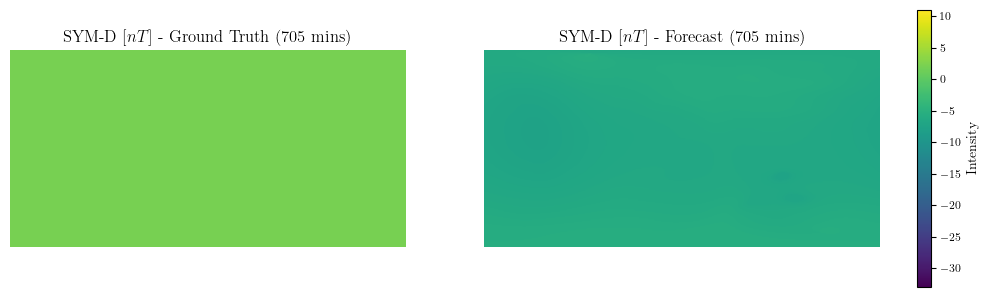

In [211]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Display animations inline in Jupyter
from IPython.display import HTML
channel = OMNI[0]
n_frames, n_channels, _, _ = unnormalized_combined_seq_original.shape
vmin = min(unnormalized_combined_seq_original[:, channel, :, :].min(), unnormalized_combined_seq_forecast[:, channel, :, :].min())
vmax = max(unnormalized_combined_seq_original[:, channel, :, :].max(), unnormalized_combined_seq_forecast[:, channel, :, :].max())
# Create figure and axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
x = np.linspace(0, 2*np.pi, 200)
im1 = ax1.imshow(np.zeros_like(unnormalized_combined_seq_original[0,0]), vmin=vmin, vmax=vmax, animated=True)
im2 = ax2.imshow(np.zeros_like(unnormalized_combined_seq_forecast[0,0]), vmin=vmin, vmax=vmax, animated=True)

ax1.set_title(f"{channel_names_figures[channel]} - Ground Truth ({0 * 15} mins)")
ax2.set_title(f"{channel_names_figures[channel]} - Forecast ({0 * 15} mins)")

for ax in (ax1, ax2):
    ax.axis("off")

# Add one shared colorbar (to the right of both subplots)
cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='vertical', fraction=0.025, pad=0.04, shrink=0.6)
cbar.set_label("Intensity")

# Update function for animation
def update(frame):
    # im1.set_array(combined_seq_original[frame, channel])
    im1.set_array(unnormalized_combined_seq_original[frame, channel])
    im2.set_array(unnormalized_combined_seq_forecast[frame, channel])

    ax1.set_title(f"{channel_names_figures[channel]} - Ground Truth ({frame * 15} mins)")
    ax2.set_title(f"{channel_names_figures[channel]} - Forecast ({frame * 15} mins)")
    return im1, im2    

# Create animation
ani = FuncAnimation(fig, update, frames=n_frames, interval=50, blit=True)

# --- save as GIF ---
import os 
# target_folder = "/home/hert7450/2025-HL-Ionosphere/results/figures"
os.makedirs(target_folder, exist_ok=True)
save_path = os.path.join(target_folder, f"forecast_vs_original_{args.event_id}_{channel_names[channel]}_ch{channel}.gif")

# Use PillowWriter for GIF export
writer = PillowWriter(fps=7)  # you can adjust fps
ani.save(save_path, writer=writer)
print(f"Saved animation to {save_path}")


# Show animation inline
HTML(ani.to_jshtml())

In [212]:
channel_names[31]

'omniweb__speed__[km_s]'

  0%|          | 0/44 [00:00<?, ?it/s]

  2%|▏         | 1/44 [00:03<02:39,  3.72s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch0_forecast_vs_original_G4H12-202304231500_JPLD_TEC.gif



  5%|▍         | 2/44 [00:07<02:44,  3.91s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch1_forecast_vs_original_G4H12-202304231500_Sun_zenith_cos.gif



  7%|▋         | 3/44 [00:11<02:41,  3.93s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch2_forecast_vs_original_G4H12-202304231500_Sun_subsolar_lat_sin.gif



  9%|▉         | 4/44 [00:17<03:09,  4.73s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch3_forecast_vs_original_G4H12-202304231500_Sun_subsolar_lon_cos.gif



 11%|█▏        | 5/44 [00:21<02:54,  4.49s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch4_forecast_vs_original_G4H12-202304231500_Sun_subsolar_lon_sin.gif



 14%|█▎        | 6/44 [00:25<02:43,  4.31s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch5_forecast_vs_original_G4H12-202304231500_Sun_antipode_lat_sin.gif



 16%|█▌        | 7/44 [00:32<03:07,  5.07s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch6_forecast_vs_original_G4H12-202304231500_Sun_antipode_lon_cos.gif



 18%|█▊        | 8/44 [00:36<02:52,  4.80s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch7_forecast_vs_original_G4H12-202304231500_Sun_antipode_lon_sin.gif



 20%|██        | 9/44 [00:40<02:38,  4.53s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch8_forecast_vs_original_G4H12-202304231500_Earth-Sun_distance_(AU).gif



 23%|██▎       | 10/44 [00:46<02:53,  5.10s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch9_forecast_vs_original_G4H12-202304231500_Moon_zenith_cos.gif



 25%|██▌       | 11/44 [00:52<02:52,  5.24s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch10_forecast_vs_original_G4H12-202304231500_Moon_sublunar_lat_sin.gif



 27%|██▋       | 12/44 [00:56<02:37,  4.91s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch11_forecast_vs_original_G4H12-202304231500_Moon_sublunar_lon_cos.gif



 30%|██▉       | 13/44 [01:00<02:19,  4.48s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch12_forecast_vs_original_G4H12-202304231500_Moon_sublunar_lon_sin.gif



 32%|███▏      | 14/44 [01:05<02:21,  4.71s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch13_forecast_vs_original_G4H12-202304231500_Moon_antipode_lat_sin.gif



 34%|███▍      | 15/44 [01:09<02:10,  4.49s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch14_forecast_vs_original_G4H12-202304231500_Moon_antipode_lon_cos.gif



 36%|███▋      | 16/44 [01:12<01:56,  4.16s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch15_forecast_vs_original_G4H12-202304231500_Moon_antipode_lon_sin.gif



 39%|███▊      | 17/44 [01:17<01:54,  4.22s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch16_forecast_vs_original_G4H12-202304231500_Earth-Moon_distance_(LD).gif



 41%|████      | 18/44 [01:22<02:01,  4.65s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch17_forecast_vs_original_G4H12-202304231500_Day_of_year_sin.gif



 43%|████▎     | 19/44 [01:29<02:12,  5.29s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch18_forecast_vs_original_G4H12-202304231500_Day_of_year_cos.gif



 45%|████▌     | 20/44 [01:33<02:00,  5.03s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch19_forecast_vs_original_G4H12-202304231500_Quasi-dipole_lat_sin.gif



/var/folders/c5/cw2vp30j5q9_qjs9kwfhkzx40000gq/T/ipykernel_4777/2741674406.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
 48%|████▊     | 21/44 [01:37<01:46,  4.63s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch20_forecast_vs_original_G4H12-202304231500_Quasi-dipole_lat_cos.gif



 50%|█████     | 22/44 [01:41<01:37,  4.44s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch21_forecast_vs_original_G4H12-202304231500_Quasi-dipole_lon_sin.gif



 52%|█████▏    | 23/44 [01:45<01:30,  4.30s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch22_forecast_vs_original_G4H12-202304231500_Quasi-dipole_lon_cos.gif



 55%|█████▍    | 24/44 [01:49<01:25,  4.28s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch23_forecast_vs_original_G4H12-202304231500_Kp.gif



 57%|█████▋    | 25/44 [01:53<01:16,  4.04s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch24_forecast_vs_original_G4H12-202304231500_Ap.gif



 59%|█████▉    | 26/44 [01:57<01:12,  4.02s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch25_forecast_vs_original_G4H12-202304231500_omniweb__sym_d__[nT].gif



 61%|██████▏   | 27/44 [02:02<01:14,  4.38s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch26_forecast_vs_original_G4H12-202304231500_omniweb__sym_h__[nT].gif



 64%|██████▎   | 28/44 [02:07<01:11,  4.44s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch27_forecast_vs_original_G4H12-202304231500_omniweb__asy_d__[nT].gif



 66%|██████▌   | 29/44 [02:10<01:03,  4.21s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch28_forecast_vs_original_G4H12-202304231500_omniweb__bx_gse__[nT].gif



 68%|██████▊   | 30/44 [02:14<00:56,  4.06s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch29_forecast_vs_original_G4H12-202304231500_omniweb__by_gse__[nT].gif



 70%|███████   | 31/44 [02:17<00:50,  3.90s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch30_forecast_vs_original_G4H12-202304231500_omniweb__bz_gse__[nT].gif



 73%|███████▎  | 32/44 [02:22<00:49,  4.15s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch31_forecast_vs_original_G4H12-202304231500_omniweb__speed__[km_s].gif



 75%|███████▌  | 33/44 [02:28<00:50,  4.57s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch32_forecast_vs_original_G4H12-202304231500_omniweb__vx_velocity__[km_s].gif



 77%|███████▋  | 34/44 [02:32<00:45,  4.60s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch33_forecast_vs_original_G4H12-202304231500_omniweb__vy_velocity__[km_s].gif



 80%|███████▉  | 35/44 [02:36<00:38,  4.28s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch34_forecast_vs_original_G4H12-202304231500_omniweb__vz_velocity__[km_s].gif



 82%|████████▏ | 36/44 [02:42<00:37,  4.75s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch35_forecast_vs_original_G4H12-202304231500_space_environment_technologies__f107_obs__.gif



 84%|████████▍ | 37/44 [02:47<00:33,  4.79s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch36_forecast_vs_original_G4H12-202304231500_space_environment_technologies__f107_average__.gif



 86%|████████▋ | 38/44 [02:51<00:28,  4.74s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch37_forecast_vs_original_G4H12-202304231500_space_environment_technologies__s107_obs__.gif



 89%|████████▊ | 39/44 [02:57<00:24,  4.91s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch38_forecast_vs_original_G4H12-202304231500_space_environment_technologies__s107_average__.gif



 91%|█████████ | 40/44 [03:03<00:20,  5.22s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch39_forecast_vs_original_G4H12-202304231500_space_environment_technologies__m107_obs__.gif



 93%|█████████▎| 41/44 [03:09<00:16,  5.47s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch40_forecast_vs_original_G4H12-202304231500_space_environment_technologies__m107_average__.gif



 95%|█████████▌| 42/44 [03:15<00:11,  5.63s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch41_forecast_vs_original_G4H12-202304231500_space_environment_technologies__y107_obs__.gif



 98%|█████████▊| 43/44 [03:21<00:05,  5.96s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch42_forecast_vs_original_G4H12-202304231500_space_environment_technologies__y107_average__.gif



100%|██████████| 44/44 [03:26<00:00,  4.69s/it]

Saved animation to ../data/gnn-final/plots/G4H12-202304231500/ch43_forecast_vs_original_G4H12-202304231500_JB08__d_st_dt__[K].gif


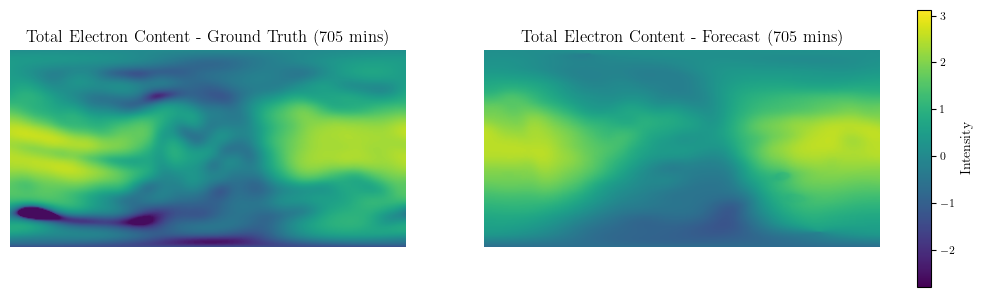

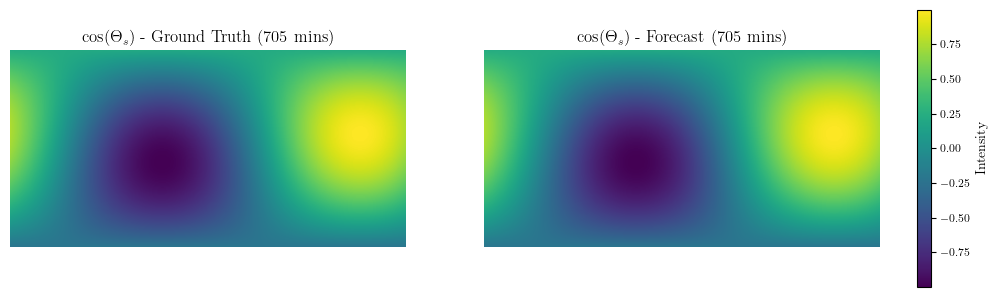

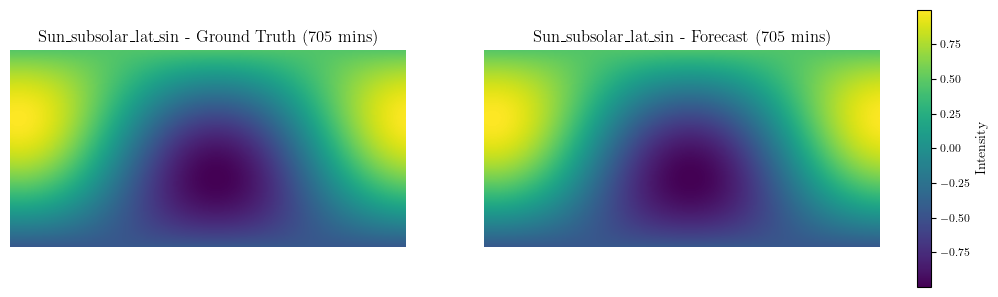

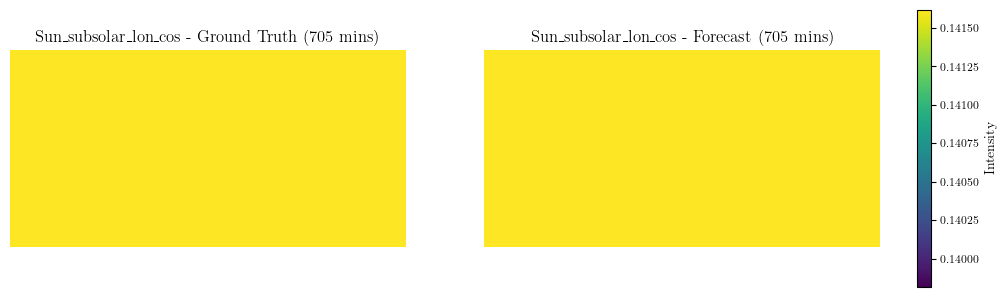

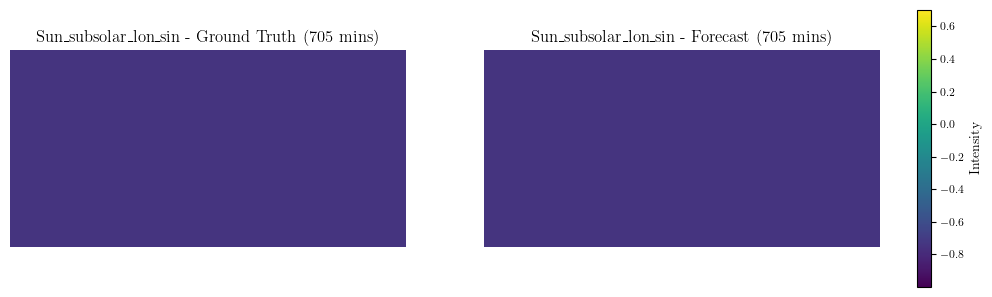

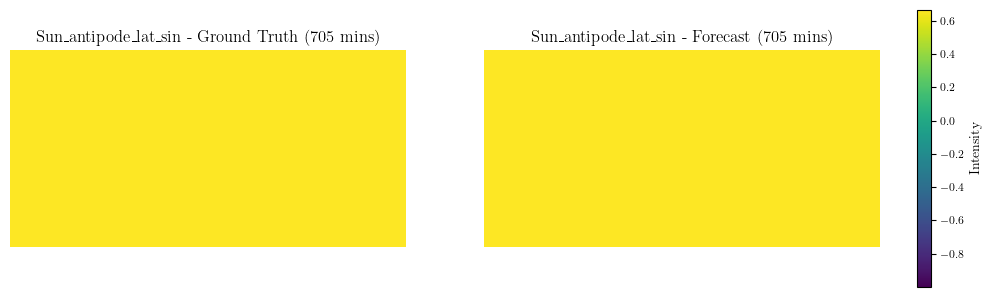

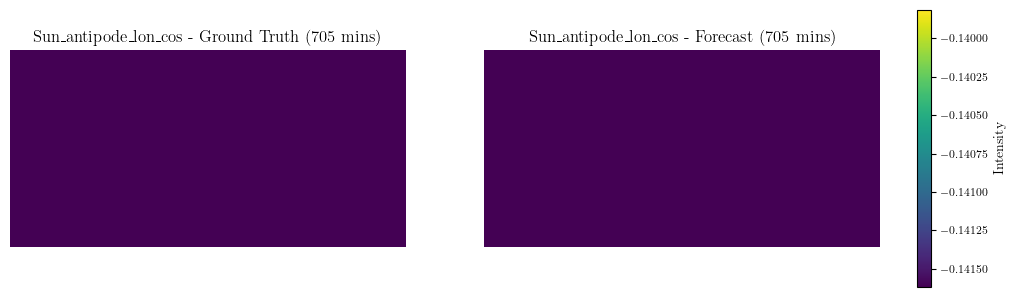

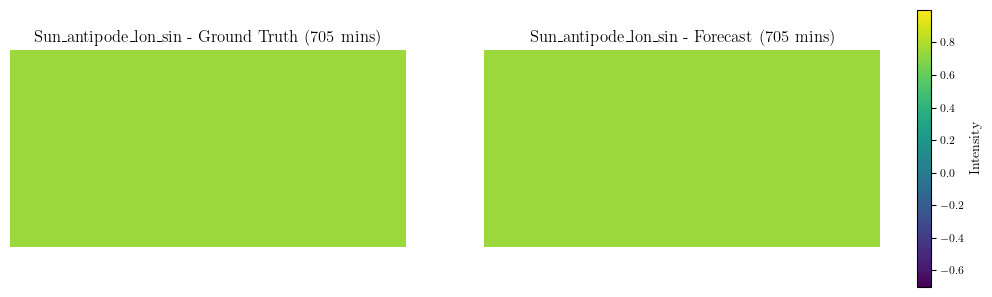

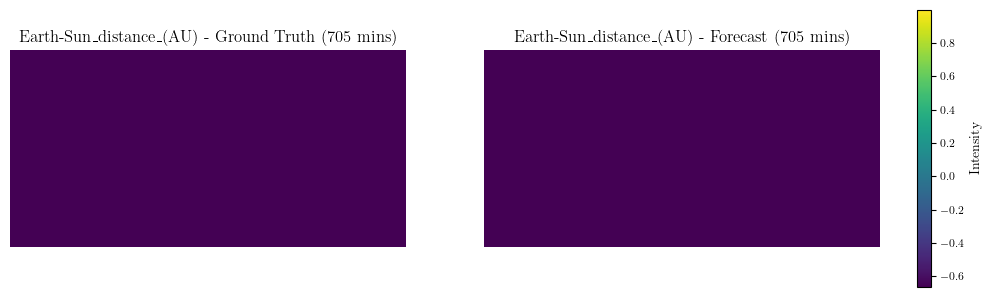

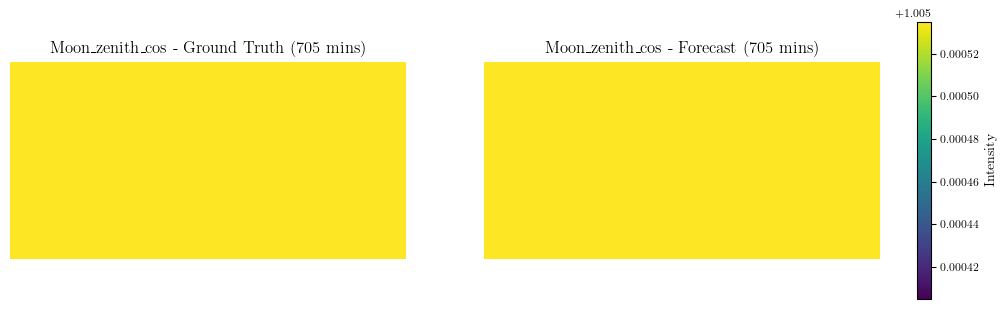

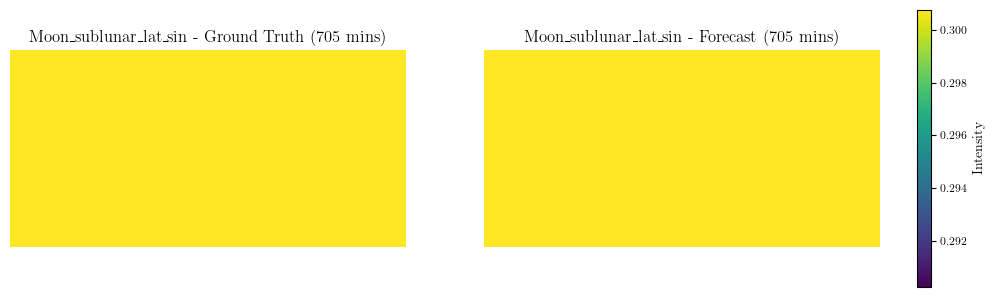

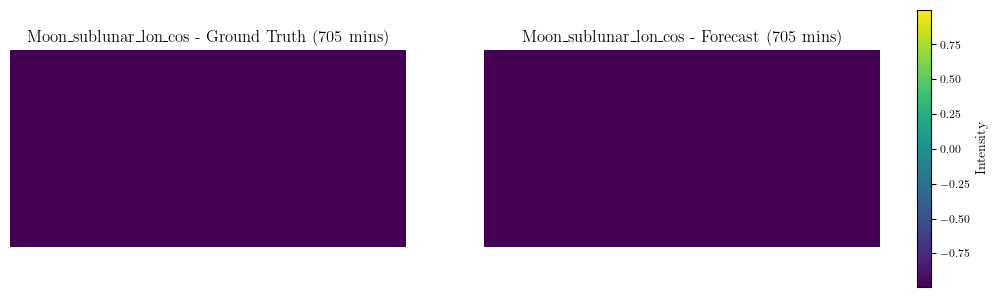

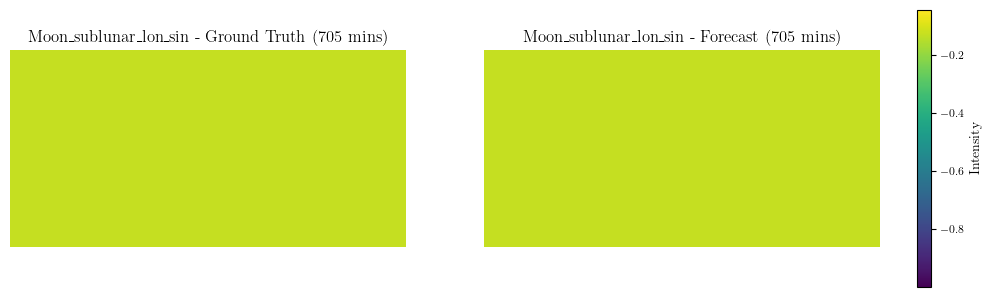

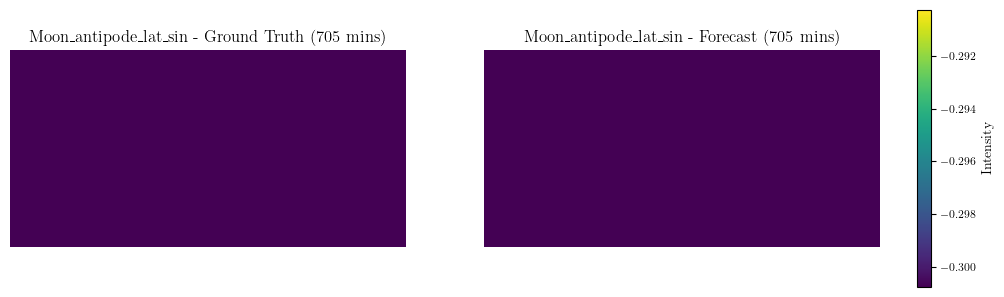

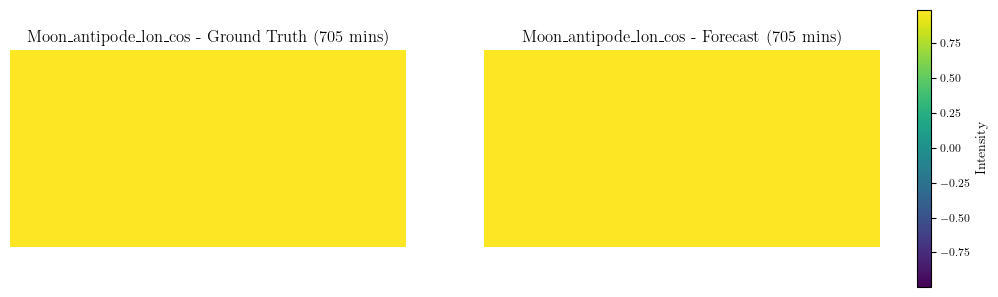

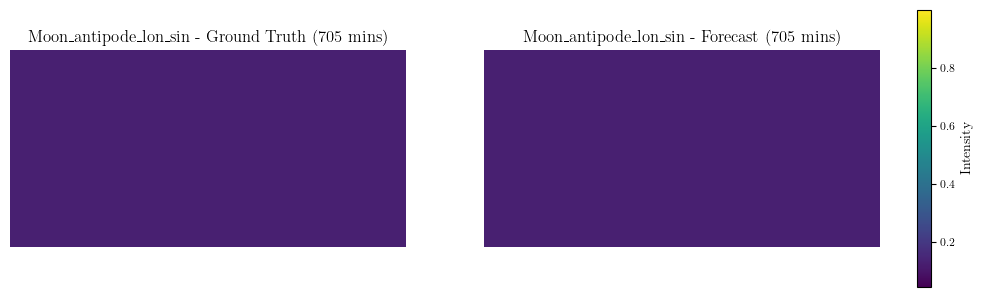

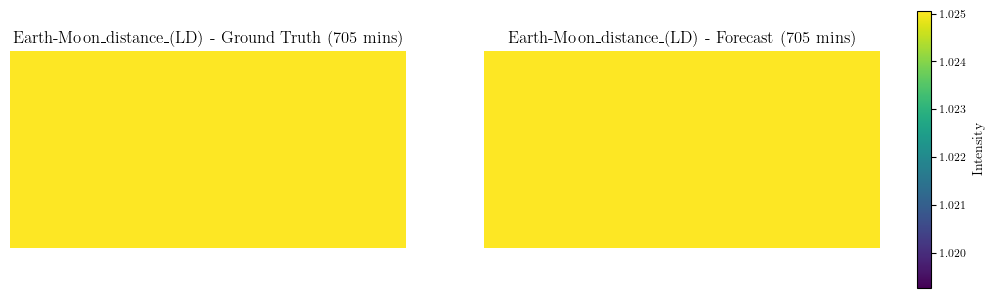

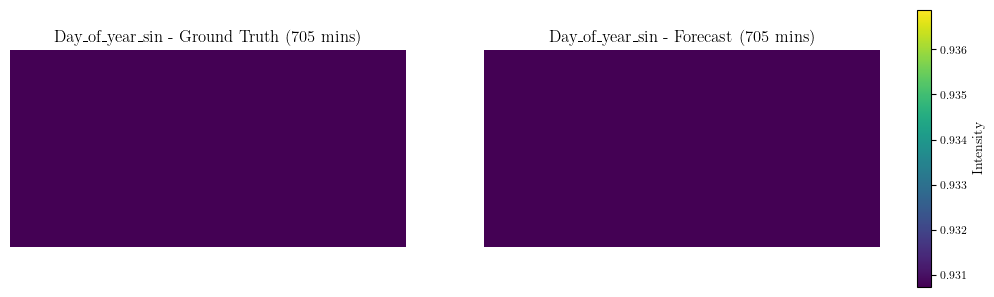

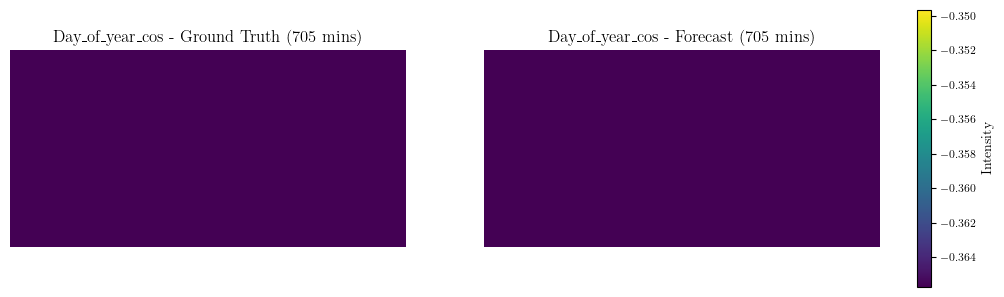

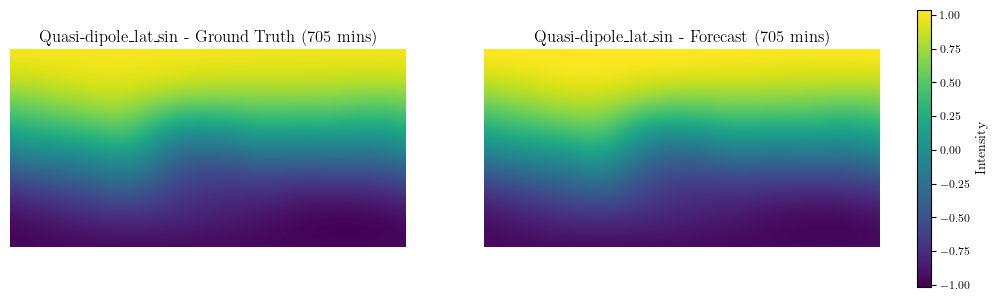

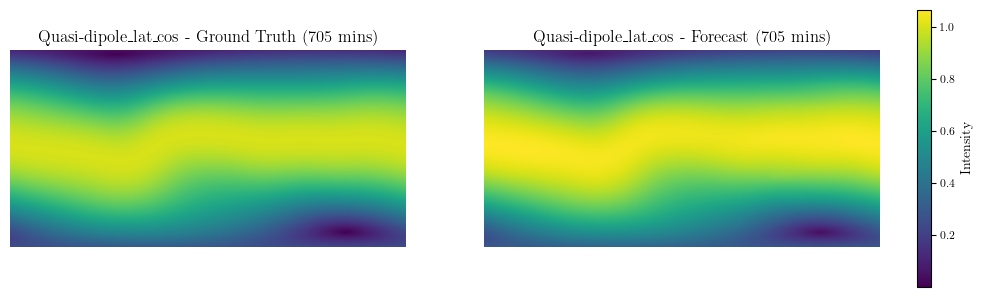

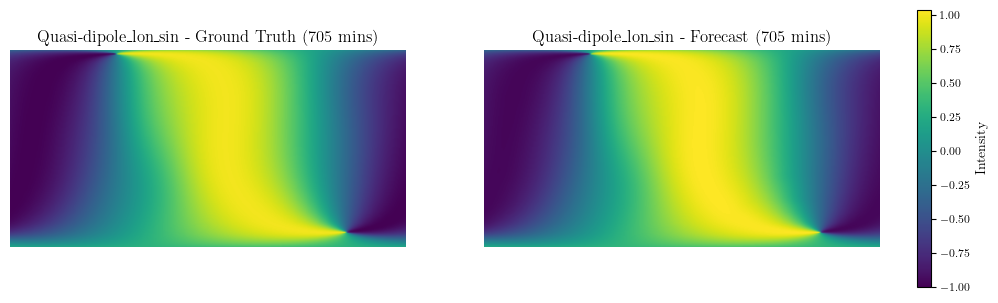

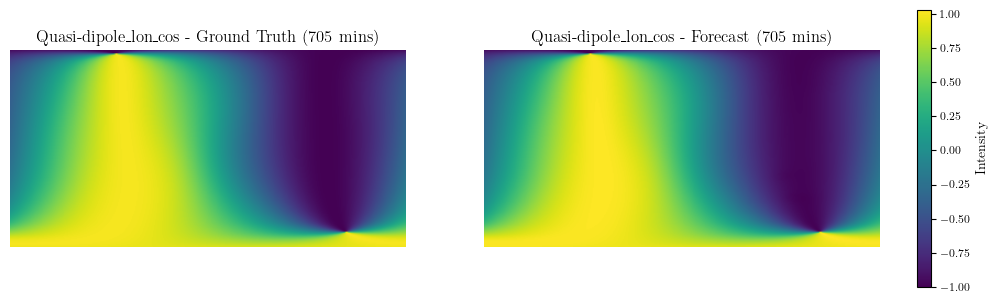

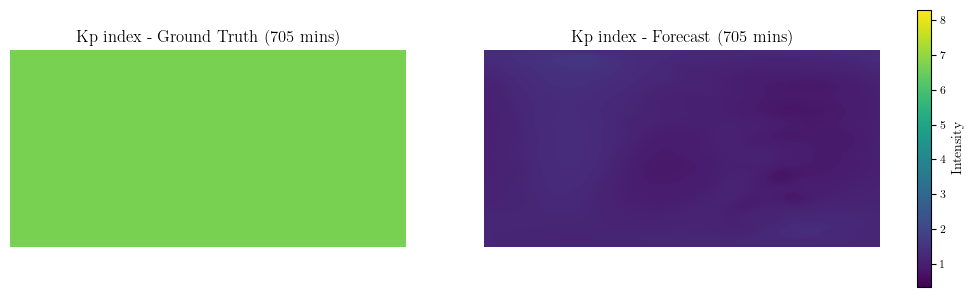

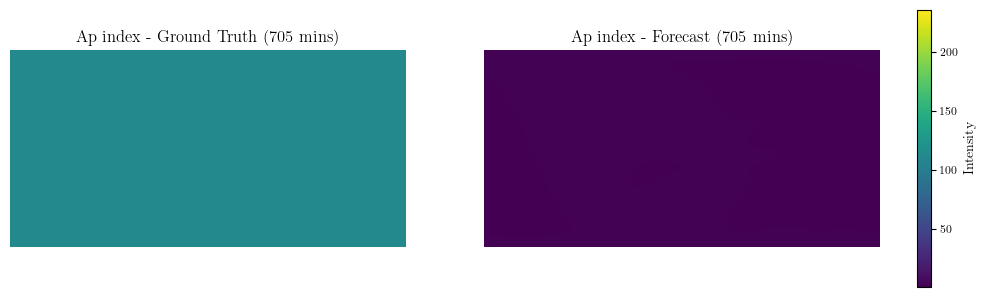

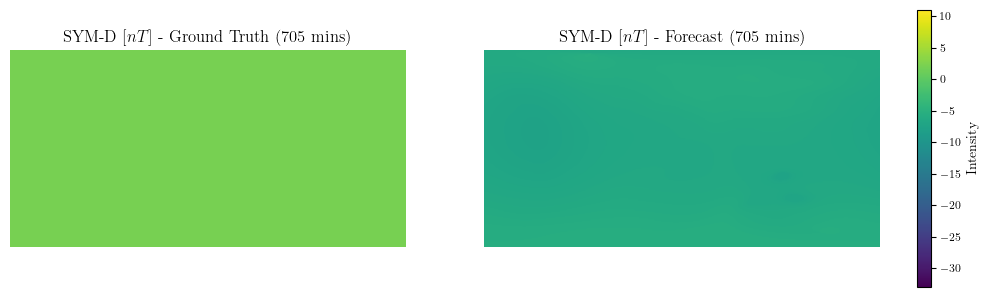

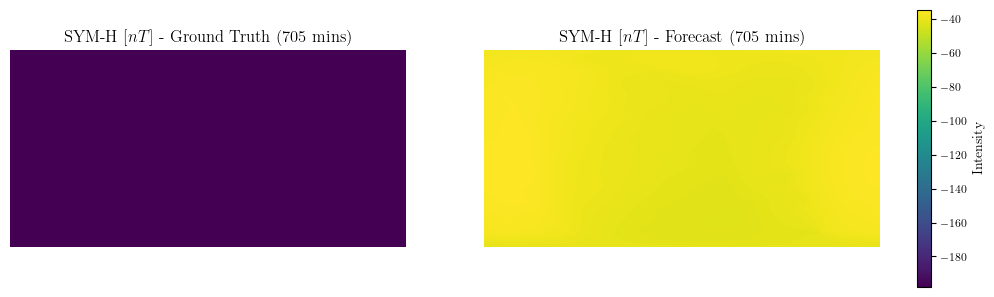

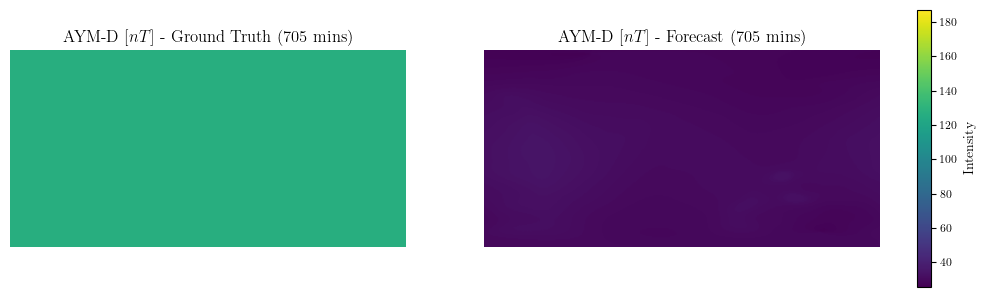

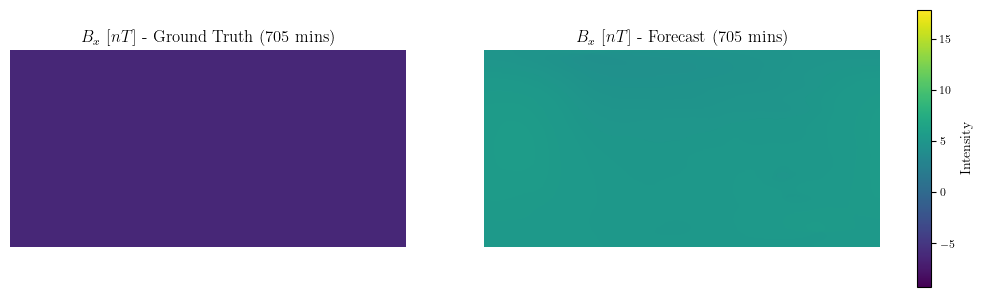

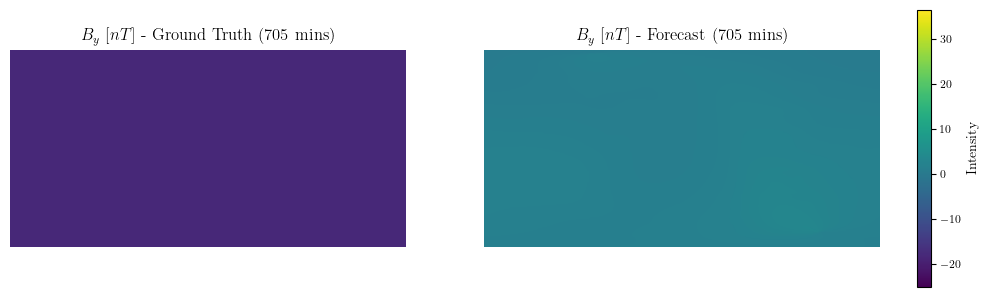

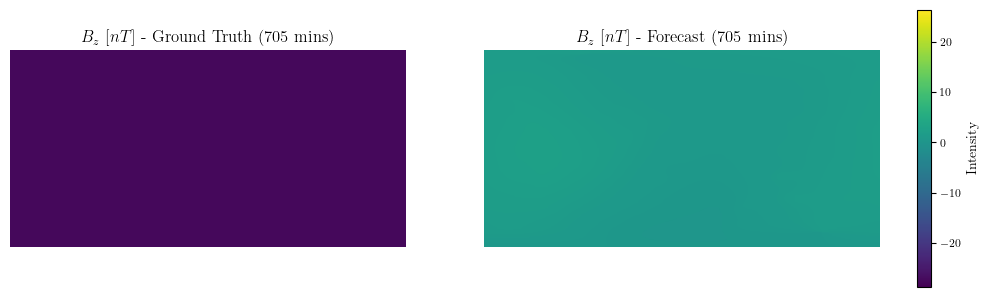

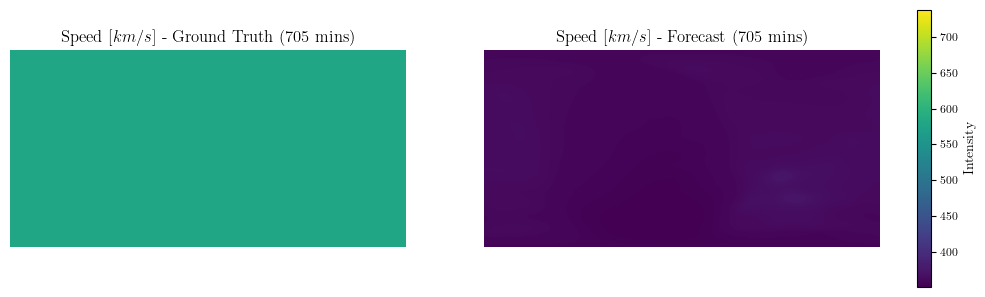

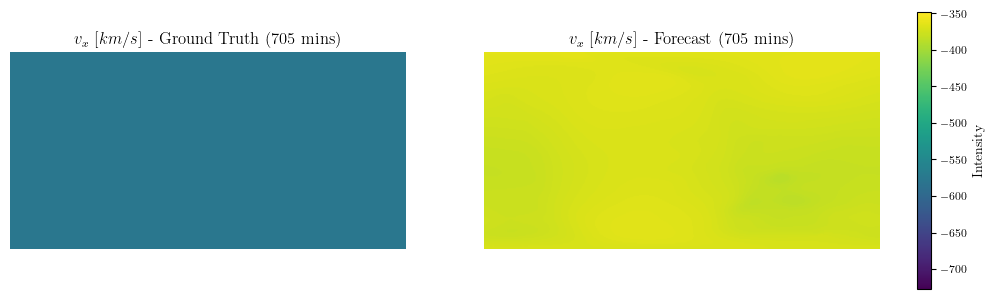

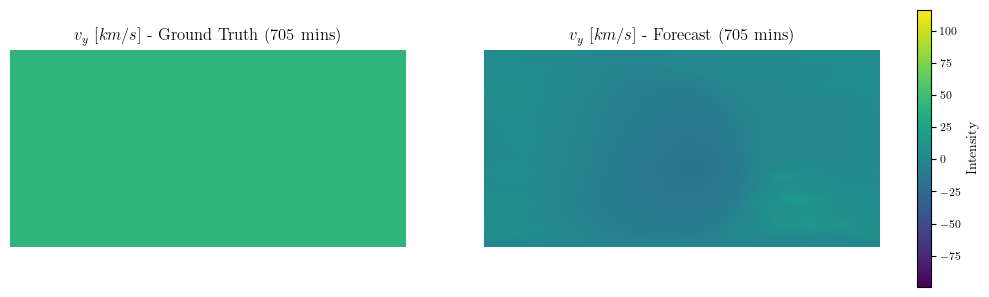

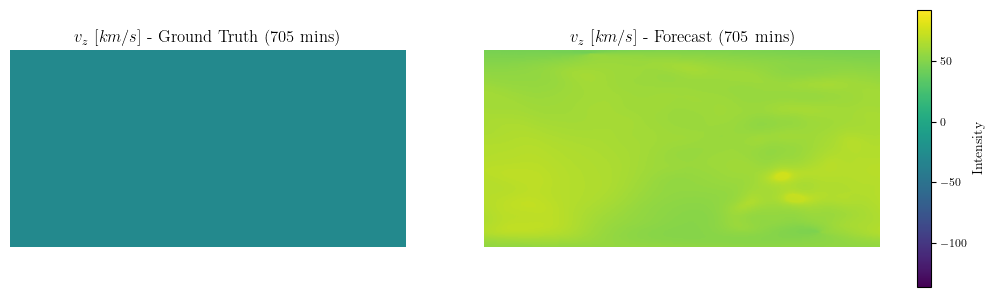

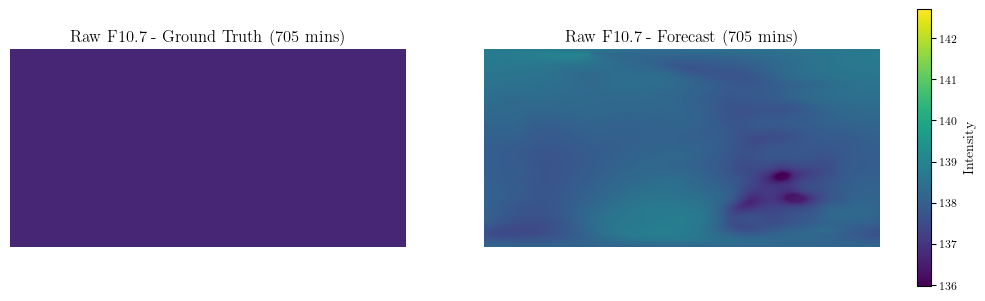

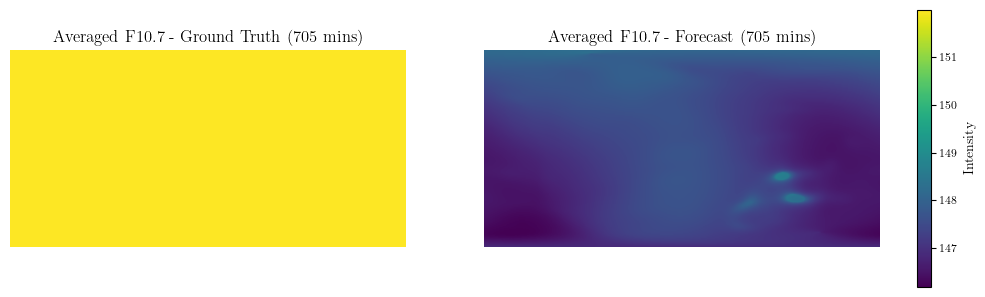

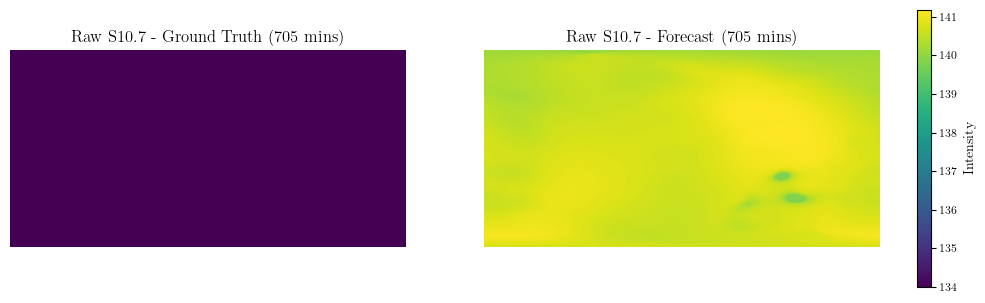

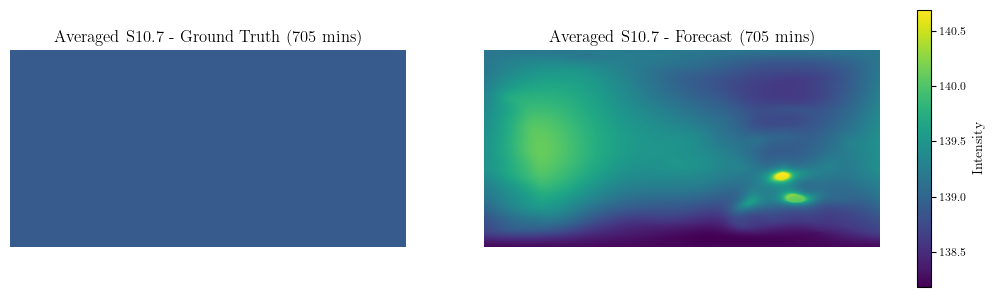

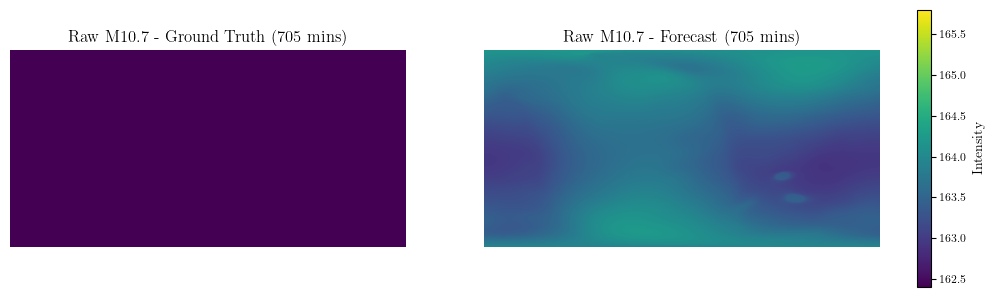

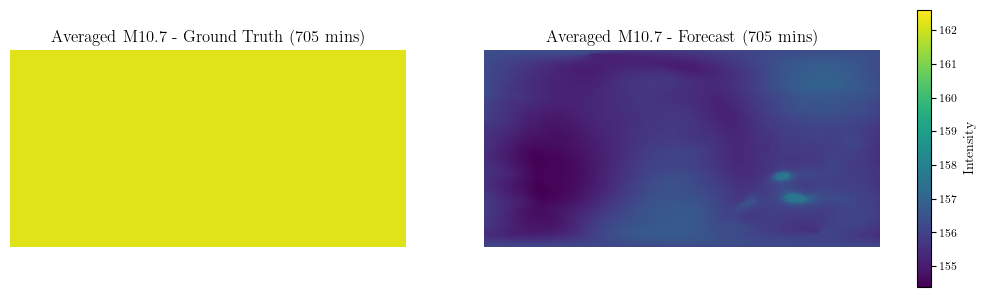

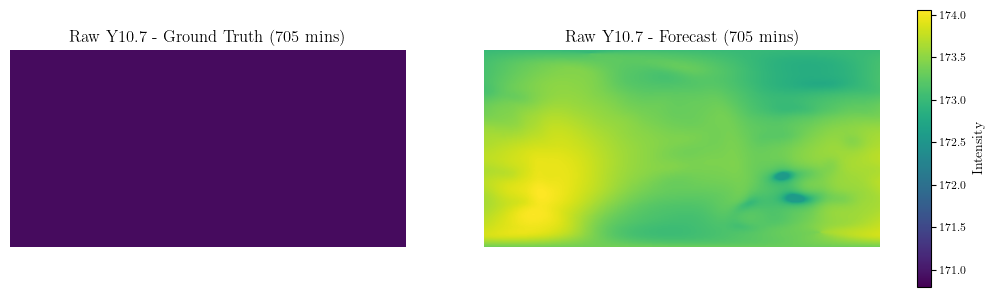

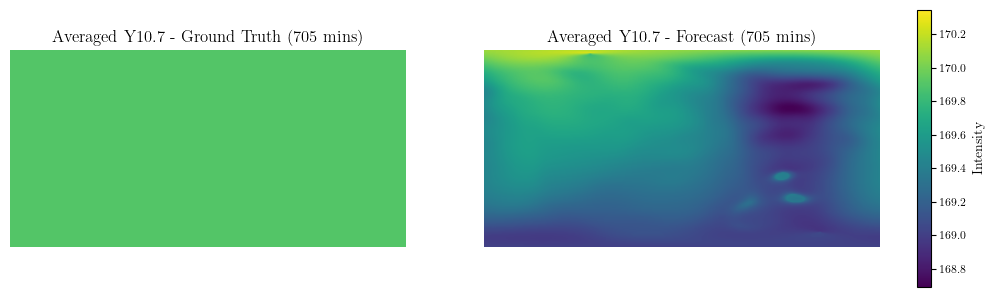

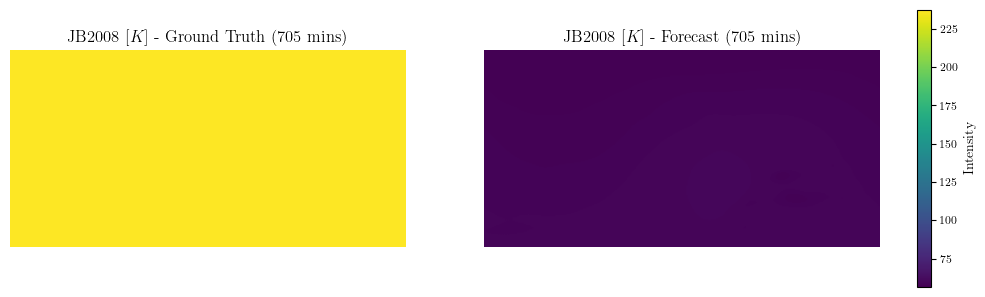

In [213]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from tqdm import tqdm
# Display animations inline in Jupyter
from IPython.display import HTML
import os 


for channel in tqdm(channels):
    # target_folder = "/home/hert7450/2025-HL-Ionosphere/results/figures"
    os.makedirs(target_folder, exist_ok=True)
    save_path = os.path.join(target_folder, f"ch{channel}_forecast_vs_original_{args.event_id}_{channel_names[channel]}.gif")
    # if os.path.exists(save_path):
    #     print(f"Skipping channel {channel} as GIF already exists.", end="\r")
    #     continue
    print()
    n_frames, n_channels, _, _ = unnormalized_combined_seq_original.shape
    vmin = min(unnormalized_combined_seq_original[:, channel, :, :].min(), unnormalized_combined_seq_forecast[:, channel, :, :].min())
    vmax = max(unnormalized_combined_seq_original[:, channel, :, :].max(), unnormalized_combined_seq_forecast[:, channel, :, :].max())
    # Create figure and axis
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    x = np.linspace(0, 2*np.pi, 200)
    im1 = ax1.imshow(np.zeros_like(unnormalized_combined_seq_original[0,0]), vmin=vmin, vmax=vmax, animated=True)
    im2 = ax2.imshow(np.zeros_like(unnormalized_combined_seq_forecast[0,0]), vmin=vmin, vmax=vmax, animated=True)

    ax1.set_title(f"{channel_names_figures[channel]} - Ground Truth ({0 * 15} mins)")
    ax2.set_title(f"{channel_names_figures[channel]} - Forecast ({0 * 15} mins)")


    for ax in (ax1, ax2):
        ax.axis("off")

    # Add one shared colorbar (to the right of both subplots)
    cbar = fig.colorbar(im1, ax=[ax1, ax2], orientation='vertical', fraction=0.025, pad=0.04, shrink=0.6)
    cbar.set_label("Intensity")

    # Update function for animation
    def update(frame):
        # im1.set_array(unnormalized_combined_seq_original[frame, channel])
        im1.set_array(unnormalized_combined_seq_original[frame, channel])
        im2.set_array(unnormalized_combined_seq_forecast[frame, channel])

        ax1.set_title(f"{channel_names_figures[channel]} - Ground Truth ({frame * 15} mins)")
        ax2.set_title(f"{channel_names_figures[channel]} - Forecast ({frame * 15} mins)")
        return im1, im2    

    # Create animation
    ani = FuncAnimation(fig, update, frames=n_frames, interval=50, blit=True)

    # --- save as GIF ---

    # Use PillowWriter for GIF export
    writer = PillowWriter(fps=7)  # you can adjust fps
    ani.save(save_path, writer=writer)
    print(f"Saved animation to {save_path}")


# Show animation inline
HTML(ani.to_jshtml())

In [214]:
combined_seq_original_average = combined_seq_original.mean(axis=(2,3))
combined_seq_forecast_average = combined_seq_forecast.mean(axis=(2,3))
unnormalized_combined_seq_original_average = unnormalized_combined_seq_original.mean(axis=(2,3))
unnormalized_combined_seq_forecast_average = unnormalized_combined_seq_forecast.mean(axis=(2,3))

In [215]:
seq_len, n_channels, H, W = combined_seq_original.shape
print(combined_seq_original.shape, combined_seq_forecast.shape)
print(combined_seq_original_average.shape, combined_seq_forecast_average.shape)
print(combined_seq_original.reshape(seq_len, n_channels, H*W).shape, combined_seq_forecast.reshape(seq_len, n_channels, H*W).shape)


(48, 44, 180, 360) (48, 44, 180, 360)
(48, 44) (48, 44)
(48, 44, 64800) (48, 44, 64800)


In [216]:
180*360

64800

In [217]:
CELESTRAK.tolist() + OMNI.tolist() + SET.tolist()

[23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43]

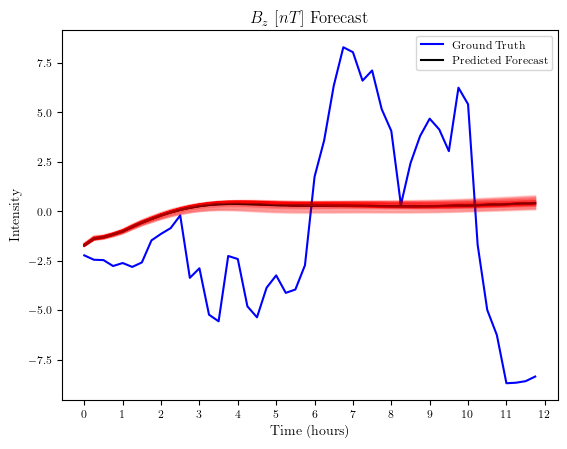

In [218]:

channel = np.random.choice(CELESTRAK.tolist() + OMNI.tolist() + SET.tolist())




seq_len, n_channels, H, W = combined_seq_original.shape
# vmin = min(combined_seq_original[:, channel, :, :].min(), combined_seq_forecast[:, channel, :, :].min())
# vmax = min(combined_seq_original[:, channel, :, :].max(), combined_seq_forecast[:, channel, :, :].max())
# Create figure and axis

samples = np.random.randint(0, H*W, size=500)
# print(samples)
sampled_forecasts = combined_seq_forecast.reshape(seq_len, n_channels, H*W)[:, channel, samples]
average_forecasts = combined_seq_forecast_average[:, channel]
ground_truth = combined_seq_original[:, channel, 0, 0] # This only makes sense for global params
timestamps = np.arange(seq_len) * 15  # in minutes

plt.plot(timestamps, ground_truth, label="Ground Truth", color="blue")
plt.plot(timestamps, average_forecasts, label="Predicted Forecast", color="black")
plt.plot(timestamps, sampled_forecasts, color="red", alpha=0.01)
plt.title(f"{channel_names_figures[channel]} Forecast")
plt.xlabel("Time (hours)")
plt.xticks(np.arange(12+1) * 60, np.arange(12+1).astype(int))
plt.ylabel("Intensity")
plt.legend()
plt.show()

In [219]:
for channel in tqdm(CELESTRAK.tolist() + OMNI.tolist() + SET.tolist()):

    seq_len, n_channels, H, W = combined_seq_original.shape


    samples = np.random.randint(0, H*W, size=100)
    # print(samples)
    sampled_forecasts = unnormalized_combined_seq_forecast.reshape(seq_len, n_channels, H*W)[:, channel, samples]
    average_forecasts = unnormalized_combined_seq_forecast_average[:, channel]
    ground_truth = unnormalized_combined_seq_original[:, channel, 0, 0] # This only makes sense for global params
    timestamps = np.arange(seq_len) * 15  # in minutes

    plt.plot(timestamps, ground_truth, label="Ground Truth", color="blue")
    plt.plot(timestamps, average_forecasts, label="Predicted Forecast", color="black")
    plt.plot(timestamps, sampled_forecasts, color="red", alpha=0.05)
    plt.title(f"{channel_names_figures[channel]}")
    plt.xlabel("Time (hours)")
    plt.xticks(np.arange(12+1) * 60, np.arange(12+1).astype(int))
    plt.ylabel("Intensity")
    plt.legend()
    plt.savefig(f"{target_folder}globals_ch{channel}_forecast_vs_original_{args.event_id}_{channel_names[channel]}.png")
    
    plt.clf()

100%|██████████| 21/21 [00:05<00:00,  4.15it/s]


<Figure size 640x480 with 0 Axes>